In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import xarray as xr
import torch

import sys
import os.path

sys.path.append(os.path.dirname(os.getcwd()))

from utils.train_test_utils import load_dataset, DatasetParameters


plt.rcParams['figure.figsize'] = (15, 7)


In [47]:
run_dir = "../output/41_20220509_175813"

Text(0.5, 1.0, 'Test APV')

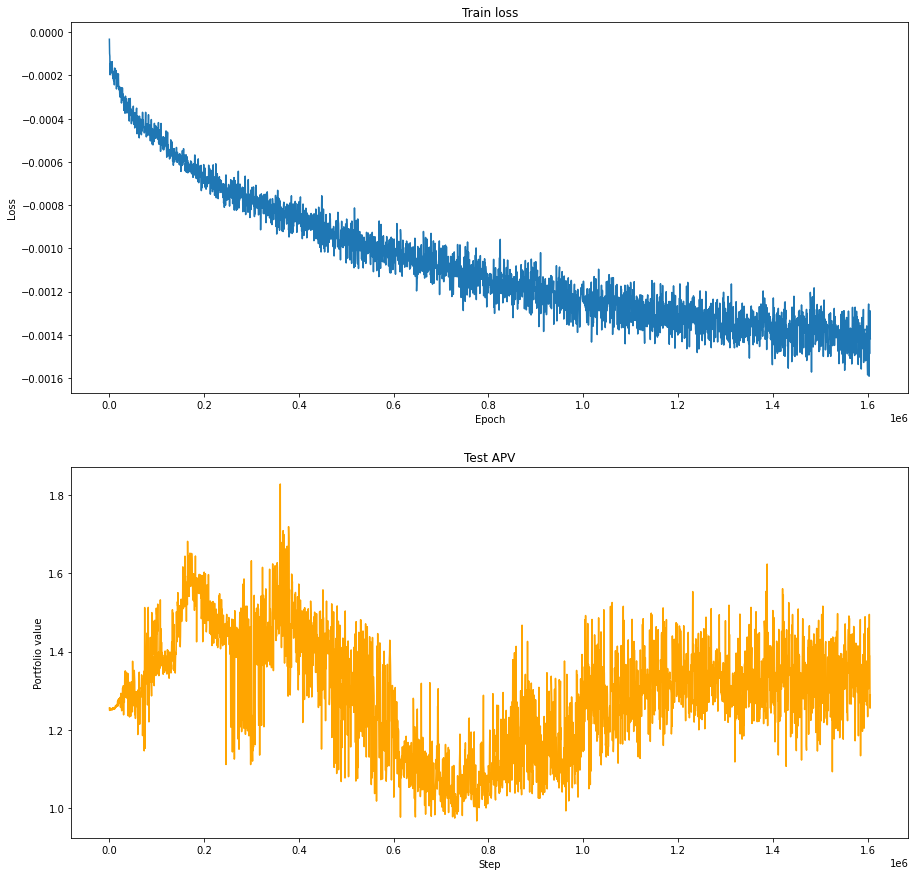

In [48]:
dataset = xr.open_dataarray(f"../data/stocks_daily/stocks_big_dataset_2022-0425.nc")
train_df = pd.read_csv(f"{run_dir}/train_log.csv")
test_df = pd.read_csv(f"{run_dir}/test_results.csv", parse_dates=['Unnamed: 0']).rename({'Unnamed: 0': 'time'}, axis=1)

plt.figure(figsize=(15,15))
plt.subplot(211)
sns.lineplot(x='epoch', y='train_loss', data=train_df)
# sns.lineplot(x='epoch', y='test_loss', data=train_df)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Train loss")
# plt.legend(labels=["Train", "Test"])

plt.subplot(212)

# sns.lineplot(x='epoch', y='train_apv', data=train_df)
sns.lineplot(x='epoch', y='test_apv', data=train_df, color='orange')
plt.ylabel('Portfolio value')
plt.xlabel('Step')
plt.title("Test APV")
# plt.legend(labels=["Train", "Test"])

In [49]:
best_epoch = train_df.iloc[np.argmax(train_df['test_apv'])]['epoch']

In [50]:
best_epoch

361000

Text(0, 0.5, 'Part of portfolio')

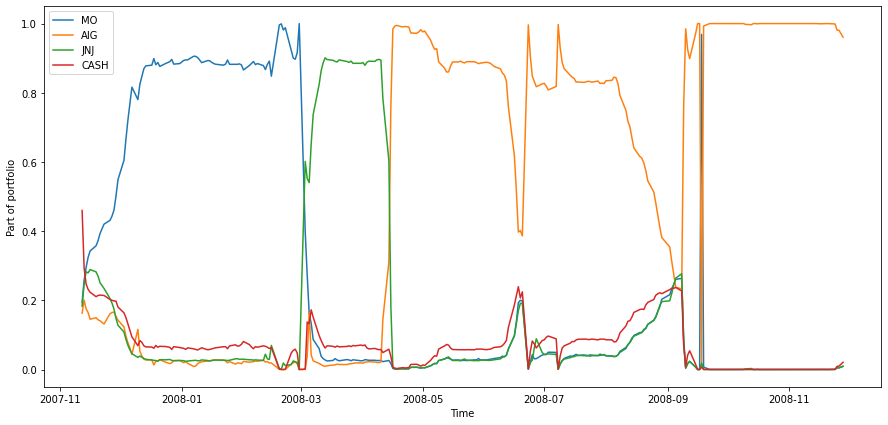

In [51]:
assets = [re.sub(r"^asset_", "", col) for col in test_df.columns if col.startswith('asset_')]
assets = list(filter(lambda asset: asset != "cash", assets)) + ['cash']

for asset in assets:
    sns.lineplot(x='time', y=f'asset_{asset}', data=test_df)
    
plt.legend(labels=[asset.upper() for asset in assets])
plt.xlabel('Time')
plt.ylabel('Part of portfolio')
    

In [52]:
time = dataset.time.to_series()
first_test_day_idx = np.argwhere(time.index == test_df['time'].iloc[0]).squeeze().item() - 1
last_test_day_idx = np.argwhere(time.index == test_df['time'].iloc[-1]).squeeze().item()

test_dataset = dataset[:, :, first_test_day_idx:last_test_day_idx+1]


Text(0, 0.5, 'Price change')

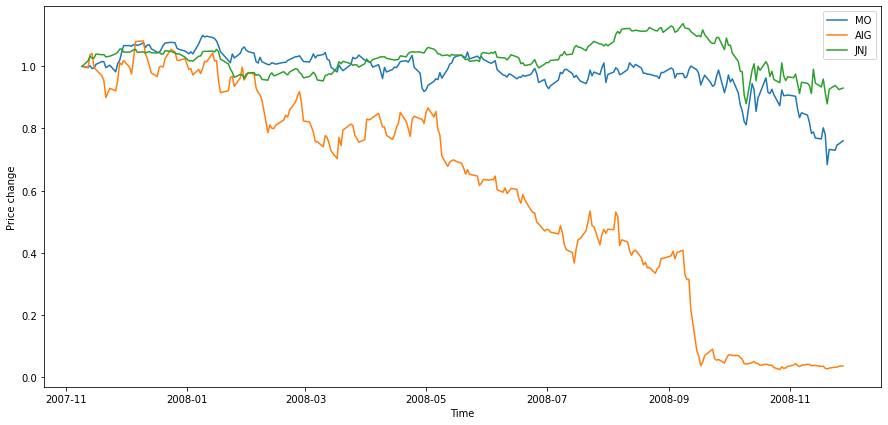

In [53]:
for asset in assets:
    if asset == "cash":
        continue
    asset_data = test_dataset.sel(asset=asset.upper(), feature='close').to_series()

    sns.lineplot(data=asset_data/asset_data[0])
    
    
plt.legend(labels=[asset.upper() for asset in assets if asset != "cash"])
plt.xlabel('Time')
plt.ylabel('Price change')

<AxesSubplot:xlabel='time', ylabel='Portfolio part'>

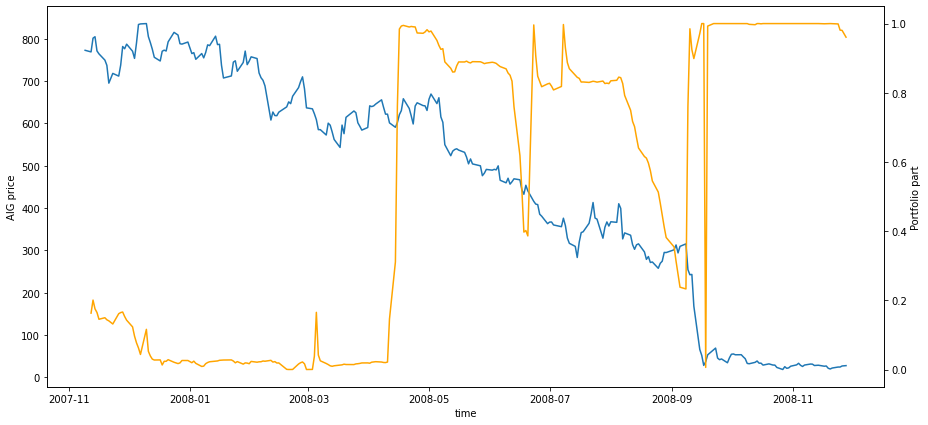

In [54]:
plt.figure(figsize=(15, 7))

asset = 'aig'

asset_data = test_dataset.sel(asset=asset.upper(), feature='close').to_series()

ax = sns.lineplot(data=asset_data)
plt.ylabel(f'{asset.upper()} price')
ax2 = ax.twinx()
plt.ylabel(f'Portfolio part')


sns.lineplot(x='time', y=test_df[f'asset_{asset}'], data=test_df, ax=ax2, color='orange')


<AxesSubplot:xlabel='time', ylabel='Price change'>

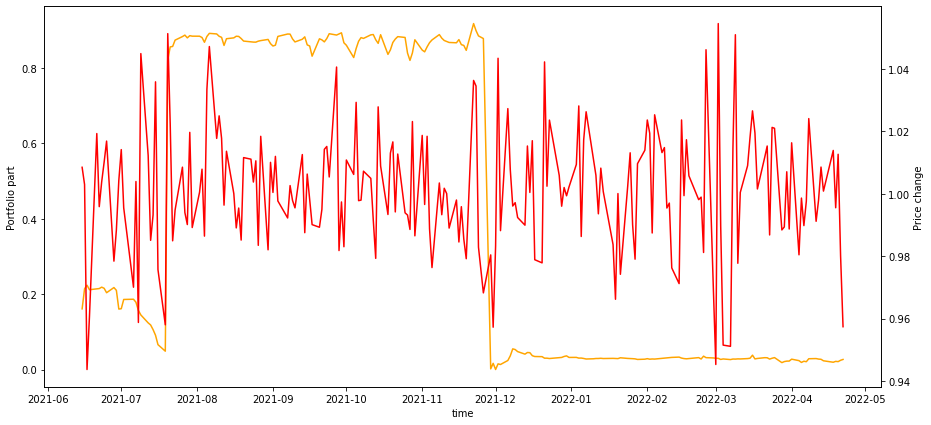

In [44]:
plt.figure(figsize=(15, 7))

ax = sns.lineplot(x='time', y=test_df[f'asset_{asset}'], data=test_df, color='orange')

plt.ylabel(f'Portfolio part')
ax2 = ax.twinx()
plt.ylabel(f'Price change')

sns.lineplot(x='time', y=test_df[f'price_change_{asset}'], data=test_df, ax=ax2, color='red')


In [45]:
# plt.figure(figsize=(15, 7))


# asset = 'spy'

# asset_data = dataset.sel(asset=asset.upper(), feature='close').to_series()
# asset_data = asset_data[asset_data.index >= test_df['time'][0]]
# # asset_data = asset_data[(asset_data.index >= test_df['time'][0]) & (asset_data.index < '2008-12-01')]


# plt.title('Our results vs S&P 500')
# sns.lineplot(x='time', y='portfolio_value', data=test_df, color='lime')
# sns.lineplot(data=asset_data/asset_data[0])


In [29]:
test_df.head()

,time,asset_cash,asset_mo,asset_aig,asset_jnj,rewards,portfolio_value,price_change_mo,price_change_aig,price_change_jnj
0,2021-06-15,0.472445,0.191707,0.160952,0.174896,0.998651,0.998651,0.996256,1.008415,0.994679
1,2021-06-16,0.304008,0.257763,0.214256,0.223972,0.997353,0.996007,0.988935,1.002911,0.999635
2,2021-06-17,0.261487,0.276975,0.223788,0.237751,0.985533,0.981598,0.989445,0.943692,1.004805
3,2021-06-18,0.258003,0.294072,0.211798,0.236128,0.983484,0.965386,0.988052,0.960632,0.980390
4,2021-06-21,0.241737,0.320908,0.214241,0.223114,1.013410,0.978331,1.021162,1.019210,1.011483


In [30]:
assets = ['MO', 'AIG', 'JNJ'] # ['XOM', 'GE', 'MSFT'] #, 'C', 'T', 'BAC', 'PG', 'WMT', 'PFE', 'MO', 'AIG', 'JNJ']

dataset_params = DatasetParameters(
    dataset='../data/stocks_daily/stocks_big_dataset_2022-0425.nc',
    x_window_size=30,
    batch_size=128,
    dataset_date_range=slice('2006-06-01', None),
    dataset_features=['close', 'high', 'low', 'open'],
    dataset_assets=assets,
    train_range=('2010-06-29', '2020-05-01'),
    validation_range=('2020-05-01', '2021-05-01'),
#     test_range=(test_df['time'].iloc[0], test_df['time'].iloc[-1])
#     test_range=('2021-05-01', '2022-04-22')
    test_range=('2021-05-01', None)
)

dm = load_dataset(dataset_params)

test_ds = dm.get_test_set_online(assets, dm._test_ind[0], dm._test_ind[-1]+1, 30, False)

trivial_model_distribution = test_ds['y'][0, 0, :, :].squeeze()

# result = gains.prod(axis=0).mean()
# gain = result - 1

In [31]:
trivial_model_performance = np.cumprod(trivial_model_distribution, axis=1).mean(axis=0)
trivial_model_performance = np.concatenate([[1], trivial_model_performance])

In [32]:
asset = 'spy'

asset_data = test_dataset.sel(asset=asset.upper(), feature='close').to_series()
asset_data.shape

(218,)

In [33]:
our_model_portfolio_value = test_df['portfolio_value'].to_numpy()
our_model_portfolio_value = np.concatenate([[1], our_model_portfolio_value])

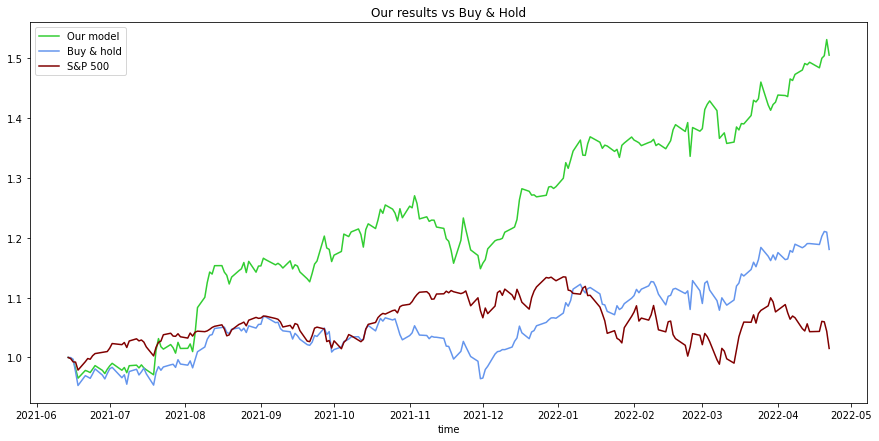

In [34]:
plt.figure(figsize=(15, 7))


# asset_data = asset_data[(asset_data.index >= test_df['time'][0]) & (asset_data.index < '2008-12-01')]

# our_model = np.concatenate([[1], test_df['portfolio_value']])

plt.title('Our results vs Buy & Hold')
sns.lineplot(x=asset_data.index, y=our_model_portfolio_value, color='limegreen')

sns.lineplot(x=asset_data.index, y=trivial_model_performance, color='cornflowerblue')

sns.lineplot(data=asset_data/asset_data[0], color='maroon')

plt.legend(labels=["Our model", "Buy & hold", "S&P 500"])